# Hate Speech Classification using 1D CNN with Tensorflow

### Task 1: Import Packages and Functions

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/NLP_2020/data')

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
print(tf.__version__)

2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Task 2: Load and Explore Data

In [4]:
# Load data
train_df= pd.read_csv('train.csv').fillna(' ')

In [5]:
train_df.sample(10,random_state=1)

,Unnamed: 0,comment_text,toxic
89753,32718,STALKER \n\nCan you please stop stalking me an...,0
100080,116425,San Salvador crime section\nit is not fair for...,0
76729,64786,gross worldwide \n\nto be added only at the en...,0
43877,73131,"""\nHahaha, print a retraction...Homie, I make ...",0
103318,143836,Correct but we should not sarcrafice a good li...,0
15334,157451,"""::Thanks, Hnsampat. Drmargi can lick it. Ti...",1
81248,44581,"You asked\nYes, you see I have edited 2500 art...",0
63285,77569,"""\n\nThe description of Symptoms is largely ba...",0
35635,128443,Title \n\nTitle should be changed to Missouri-...,0
5017,100826,Peter Sutcliffe article \n\nAs per the Peter S...,0


In [6]:
# View few toxic comments
x = train_df['comment_text']
y = train_df['toxic']

In [7]:
train_df[train_df.toxic==1]

,Unnamed: 0,comment_text,toxic
4,30627,Sannse is a big fat bitch for not leaving the ...,1
28,44647,Who cares asshole? Stop terrorizing wikipedia ...,1
33,119469,"To everyone that has now been outed, you can t...",1
35,139089,Listen here faggot im not in the mood for your...,1
37,82945,I see you have resorted to bullying tactics\n\...,1
...,...,...,...
111667,58263,WTF \n\nDo you honestly have no life worthless...,1
111676,158878,"Umm, maybe you should block AOL proxies perman...",1
111688,7587,dogs fucked the pope \n\nWHARRRBL GRRRBL,1
111690,125094,Back again! \n\nHey I'm back. Gonna vandalize ...,1


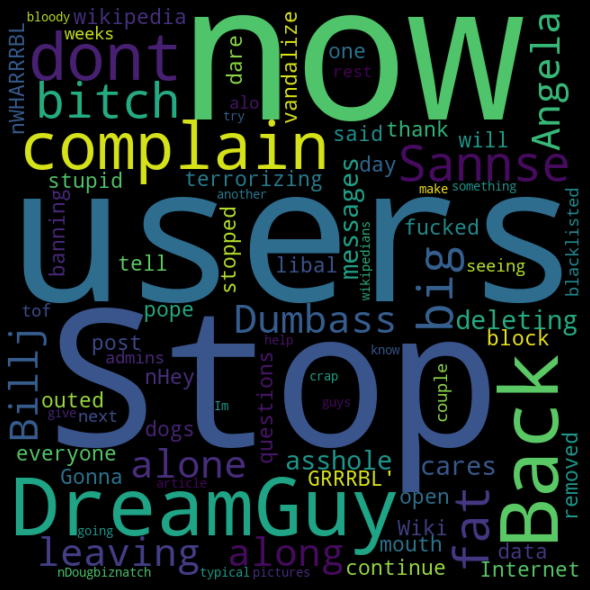

In [8]:
comments = train_df['comment_text'].loc[train_df['toxic']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


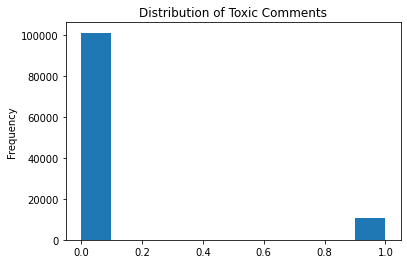

In [9]:
# Plot frequency of toxic comments
train_df['toxic'].plot(kind='hist',title='Distribution of Toxic Comments')

In [10]:
train_df['toxic'].value_counts()

0    101016
1     10684
Name: toxic, dtype: int64

### Task 3: Data Prep — Tokenize and Pad Text Data

In [11]:
max_features = 20000
max_text_length = 400

In [12]:
x_tokenizer = text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(x))

In [13]:
x_tokenized =x_tokenizer.texts_to_sequences(x)
x_train_val= sequence.pad_sequences(x_tokenized,maxlen=max_text_length)

### Task 4: Prepare Embedding Matrix with Pre-trained GloVe Embeddings

In [14]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [15]:
embedding_dim =100
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:],dtype='float32')
    embeddings_index[word]= coefs
f.close()
print(f'Found {len(embeddings_index)} word vectors')

Found 400000 word vectors


In [16]:
embedding_matrix= np.zeros((max_features,embedding_dim))
for word, index in x_tokenizer.word_index.items():
    if index>max_features-1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index]= embedding_vector
            

### Task 5: Build the Model

In [17]:
filters= 250
kernel_size=3
hidden_dims= 250


In [18]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                    trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2000000   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 250)         75250     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 250)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         312750    
_________________________________________________________________
global_max_pooling1d (Global (None, 250)               0         
_________________________________________________________________
dense (Dense)                (None, 250)               6

### Task 6: Compile Model

In [19]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

### Task 7: Splitting the data into training and validation set

In [20]:
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y,test_size=0.3,random_state=1)

### Task 8: Model Fitting/Training

In [21]:
batch_size= 32
epochs = 3
hist = model.fit(x_train,y_train,
                    batch_size= batch_size,
                    epochs=epochs,
                    validation_data= (x_val,y_val)
                    )

Epoch 1/3
2444/2444 [==============================] - 27s 11ms/step - loss: 0.1542 - accuracy: 0.9450 - val_loss: 0.1236 - val_accuracy: 0.9545
Epoch 2/3
2444/2444 [==============================] - 27s 11ms/step - loss: 0.1247 - accuracy: 0.9540 - val_loss: 0.1157 - val_accuracy: 0.9563
Epoch 3/3
2444/2444 [==============================] - 27s 11ms/step - loss: 0.1113 - accuracy: 0.9588 - val_loss: 0.1137 - val_accuracy: 0.9583


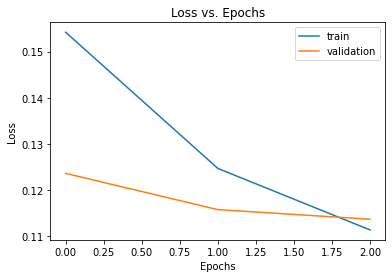

In [22]:
# Plot loss
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.legend()
plt.show()

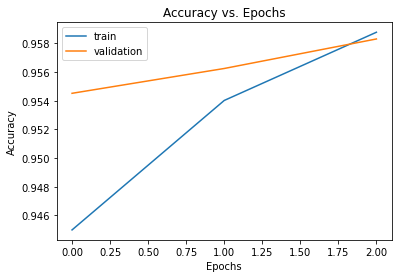

In [23]:
# Plot accuracy
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epochs')
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(x_val)
y_pred = [0 if y[0] < 0.5 else 1 for y in y_pred]

In [26]:
print("F1 Score: {:.6f}".format(f1_score(y_val, y_pred, average='macro')))

F1 Score: 0.867393


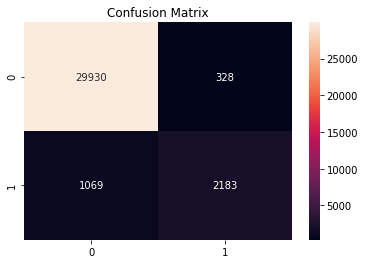

In [27]:
cm = confusion_matrix(y_val, y_pred)
f = sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()

### Task 9: Evaluate Model

In [28]:
test_df = pd.read_csv('test.csv')
x_test= test_df['comment_text'].values

In [29]:
x_test_tokenized = x_tokenizer.texts_to_sequences(x_test)
x_testing = sequence.pad_sequences(x_test_tokenized,maxlen=max_text_length)

In [30]:
y_testing= model.predict(x_testing,verbose=1,batch_size=32)

1436/1436 [==============================] - 6s 4ms/step


### Extras: To view our results!

In [31]:
test_df['toxic'] = [ 'not toxic' if x<0.5 else 'toxic' for x in y_testing]

In [32]:
test_df[['comment_text','toxic']].head(20)

,comment_text,toxic
0,"You are the one being vandalistic, with vague ...",not toxic
1,:::Maybe but we can't use Wikipedia as referen...,not toxic
2,""" \n :So let me get this right: the MoS used t...",not toxic
3,I hate you people.,toxic
4,:Apology accepted.,not toxic
5,You are a gay fuck and I hope you die.,toxic
6,""" \n : It was mostly from 3 or 4 websites. I'm...",not toxic
7,""" \n ::::::Heck I'd rather see the news of Alb...",not toxic
8,Have you lost your mind? Are you picking on me...,not toxic
9,== Your break == \n\n I hope you're doing alri...,not toxic
